# Model 1. Accuracy of pointer-based endonasal image-guidance system

The current state of the art uses a tracked pointer, registered to a pre-operative MR scan. This notebook explores what the expected level of accuracy might be.






In [38]:
import copy
import numpy as np
import cv2
import random
from scipy.spatial.transform import Rotation as spr
from matplotlib import pyplot as plt
import sksurgerycore.algorithms.procrustes as pro
import sksurgerycore.transforms.matrix as mu


## Utility functions

Here follows some useful utility functions. Scroll down to see the start of the analysis. Ideally these would be in some common library, as pasting utility functions into a Jupyter notebook tends to lead to duplication.

In [39]:
def create_transform(array_of_parameters):
    """
    Returns a homogeneous rigid transformation as 4x4 np.ndarray.
    
    :param array_of_parameters: list of [tx, ty, tz, rx, ry, rz] where rotations are in degrees.
    """
    rotation = mu.construct_rotm_from_euler(array_of_parameters[3],
                                            array_of_parameters[4],
                                            array_of_parameters[5],
                                            sequence='xyz',
                                            is_in_radians=False)
    translation = np.zeros((3,1))
    translation[0][0] = array_of_parameters[0]
    translation[1][0] = array_of_parameters[1]
    translation[2][0] = array_of_parameters[2]
    
    transform = mu.construct_rigid_transformation(rotation, translation)
    return transform
    
def multiply_points_by_matrix(matrix_4x4, matrix_of_points, do_transpose):
    """
    Multiplies all points by the same matrix.
    
    :param matrix_4x4: Numpy ndarray, 4x4, containing homogenous, rigid transformation
    :param matrix_of_points: Numpy ndarray, 4xN, containing N points as 4D homogeneous column vectors.
    :param do_transpose: if true, we also transpose
    """
    input_matrix = matrix_of_points
    
    if do_transpose:
        input_matrix = np.transpose(matrix_of_points)
        
    result = np.matmul(matrix_4x4, input_matrix)
    
    if do_transpose:
        result = np.transpose(result)
        
    return result

def multiply_point_by_matrix(transform, point_as_array):
    in_point = np.ones((4, 1))
    in_point[0][0] = point_as_array[0]
    in_point[1][0] = point_as_array[1]
    in_point[2][0] = point_as_array[2]
    out_point = np.matmul(transform, in_point)
    return out_point
    
def pointer_to_mri(Cam_T_PntRef, Cam_T_PatRef, PatRef_T_MRI, point_in_pointer_coords=[0, 0, 0]):
    """
    Converts a point in pointer space to MRI space.
    """
    transform = np.linalg.inv(PatRef_T_MRI) @ np.linalg.inv(Cam_T_PatRef) @ Cam_T_PntRef
    out_point = multiply_point_by_matrix(transform, point_in_pointer_coords)
    return out_point

def camera_to_mri(Cam_T_Endo, Cam_T_PatRef, PatRef_T_MRI, Eye_T_Hand, point_in_camera_coords=[0, 0, 0]):
    """
    Converts a point in camera space to MRI space.
    """
    transform = np.linalg.inv(PatRef_T_MRI) @ np.linalg.inv(Cam_T_PatRef) @ Cam_T_Endo @ np.linalg.inv(Eye_T_Hand)
    out_point = multiply_point_by_matrix(transform, point_in_camera_coords)
    return out_point

def mri_to_camera(Cam_T_Endo, Cam_T_PatRef, PatRef_T_MRI, Eye_T_Hand, point_in_mri_coords=[0, 0, 0]):
    """
    Converts a point in camera space to MRI space.
    """
    transform = np.linalg.inv(PatRef_T_MRI) @ np.linalg.inv(Cam_T_PatRef) @ Cam_T_Endo @ np.linalg.inv(Eye_T_Hand)
    transform = np.linalg.inv(transform)
    out_point = multiply_point_by_matrix(transform, point_in_mri_coords)
    return out_point

def add_noise_to_points(points_in, sigma):
    points_out = np.zeros((points_in.shape))
    for r in range(points_in.shape[0]):
        for c in range(points_in.shape[1]):
            multiplier = 1.0
            if c >= 2:
                multiplier = 1.0 # for if you want different noise in tracker z-direction
            points_out[r][c] = points_in[r][c] + (random.normalvariate(0, sigma) * multiplier)
    return points_out

def add_noise_to_params(params, sigma):
    params_out = copy.deepcopy(params)
    for i, p in enumerate(params):
        params_out[i] = params[i] + random.normalvariate(0, sigma)
    return params_out

def extract_rigid_body_parameters(matrix):
    t = matrix[0:3, 3]
    r = matrix[0:3, 0:3]
    rot = spr.from_matrix(r)    
    euler = rot.as_euler('zyx', degrees=True)
    return [euler[0], euler[1], euler[2], t[0], t[1], t[2]]

def rigid_body_parameters_to_matrix(params):
    matrix = np.eye(4)
    r = (spr.from_euler('zyx', [params[0], params[1], params[2]], degrees=True)).as_matrix()
    matrix[0:3, 0:3] = r
    matrix[0][3] = params[3]
    matrix[1][3] = params[4]
    matrix[2][3] = params[5]
    return matrix

def convert_4x1_to_1x1x3(p_41):
    p_113 = np.zeros((1,1,3))
    p_113[0][0][0] = p_41[0][0]
    p_113[0][0][1] = p_41[1][0]
    p_113[0][0][2] = p_41[2][0]
    return p_113

def project_camera_point_to_image(point, intrinsics, distortion):
    rvec = np.zeros((1,3))
    tvec = np.zeros((1,3))
    image_points, jacobian = cv2.projectPoints(convert_4x1_to_1x1x3(point), rvec, tvec, intrinsics, distortion)
    return image_points[0][0] # returns a list


## System layout

The following diagram shows the layout of the navigation system.

![img](./images/pointer_setup.png)

In the above image, we can see the general setup involved in the surgery when using a pointer. The goal is to be able to display the pointer in image coordinates as we can see in the image below:

![pointer on MRI](./images/MRI_pointer.png)

The goal is therefore turning the pointer's coordinates to MRI coordinates.

X<sub>MRI</sub> = T X<sub>PntEnd</sub>

where T are the transformations involved in turning from the pointer's point to the MRI coordinates. These transformations are the following:

T = <sup>MRI</sup>T<sub>PatRef</sub> * 
    <sup>PatRef</sup>T<sub>Cam</sub>  * 
    <sup>Cam</sup>T<sub>PntRef</sub> * 
    <sup>PntRef</sup>T<sub>endP</sub>
    
In the following sections we will go step by step on how to go from each of these transforms

Here is an image with all the transforms:

![pointer setup with transforms](./images/pointer_setup_transforms.png)

## Assumptions / setup

1. Cancer, patient reference, pointer reference are all aligned in z direction (have same z coordinate) and are facing the camera straight on so that the distance is D

2. Patient reference is at a set distance Yc from the cancer but aligned in the X direction

3. pointer is touching the cancer, so the pointer and cancer have the same coordinates

4. Length of pointer is known

5. Angle of pointer is known

![pointer assumptions from sagittal view](./images/pointer_setup_assumptions_sagittal.png)
![pointer assumptions from transverse view](./images/pointer_setup_assumptions_transverse.png)

## Configurable parameters

In [40]:
# ALL MEASUREMENTS IN MM

# P - length from tip of pointer to reference of pointer
pointer_length = 100

# D - z distance from camera to plane where everything is located
distance_from_cam = 1000 # since the camera and patient reference are aligned in the x and y directions, only distance is in z

# 0 - angle of pointer
pointer_angle = 45

# Yc - distances from cancer to patient reference
cancer_patref_y = 50  

# NDI quotes 0.25mm for Polaris Spectra, some papers estimate it at 0.17mm
typical_tracking_sigma = 0.25

# For Model 2 and 3, using an endoscope, this determines the distance of a target of interest from the endoscope.
working_distance = 50

# For Model 2 and 3, the length of the endoscope.
length_of_endoscope = 300


## Creating the reference data for the pointer, in pointer coordinates.

Here is an image of the pointer with its reference:

![pointer image](./images/pointer_image.png)
![pointer image](./images/pointer_geometry.png)

In our case, let us assume we already know what the length of the pointer is.

In [41]:
print(f'pointer length is: {pointer_length}mm' )

pointer length is: 100mm


[[  0.   0.   0.   1.]
 [  0.   0.  50.   1.]
 [  0.  25. 100.   1.]
 [  0. -25. 135.   1.]]


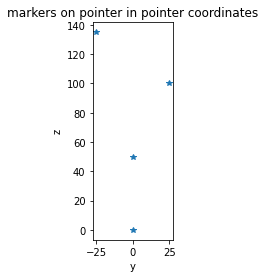

In [42]:
# Creating pointer reference (from datasheet). Using homogenous (4 numbers, x,y,z,1) as row vectors.
pnt_ref =  np.zeros((4, 4))
pnt_ref[0][3] = 1
pnt_ref[1][2] = 50
pnt_ref[1][3] = 1
pnt_ref[2][1] = 25
pnt_ref[2][2] = 100
pnt_ref[2][3] = 1
pnt_ref[3][1] = -25
pnt_ref[3][2] = 135
pnt_ref[3][3] = 1
print(pnt_ref)

# Plotting original points, to check it looks ok.
plt.figure()
plt.plot(pnt_ref[:,1],pnt_ref[:,2], marker='*',linestyle = 'None',)
plt.title('markers on pointer in pointer coordinates')
plt.xlabel('y')
plt.ylabel('z')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()


Original pointer, as per datasheet:
[[  0.   0.   0.   1.]
 [  0.   0.  50.   1.]
 [  0.  25. 100.   1.]
 [  0. -25. 135.   1.]]
offset_pointer_transform=
[[  1.   0.   0.   0.]
 [  0.   1.   0.   0.]
 [  0.   0.   1. 100.]
 [  0.   0.   0.   1.]]
pnt_ref_transformed=
[[  0.   0. 100.   1.]
 [  0.   0. 150.   1.]
 [  0.  25. 200.   1.]
 [  0. -25. 235.   1.]]
pnt_ref_with_tip=
[[  0.   0. 100.   1.]
 [  0.   0. 150.   1.]
 [  0.  25. 200.   1.]
 [  0. -25. 235.   1.]
 [  0.   0.   0.   1.]]


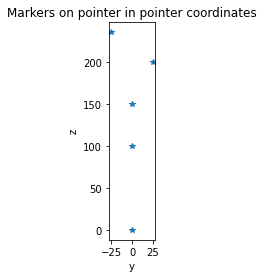

In [43]:
# Here we offset the points by the length of the pointer.
offset_pointer_transform = create_transform([0, 0, pointer_length, 0, 0, 0])
pnt_ref_transformed = multiply_points_by_matrix(offset_pointer_transform, pnt_ref, do_transpose=True)
pnt_ref_with_tip = np.concatenate((pnt_ref_transformed, [[0, 0, 0, 1]]), axis=0)

print("Original pointer, as per datasheet:\n" + str(pnt_ref))
print("offset_pointer_transform=\n" + str(offset_pointer_transform))
print("pnt_ref_transformed=\n" + str(pnt_ref_transformed))
print("pnt_ref_with_tip=\n" + str(pnt_ref_with_tip))

plt.figure()
plt.plot(pnt_ref_with_tip[:,1],pnt_ref_with_tip[:,2], marker='*',linestyle = 'None',)
plt.title('Markers on pointer in pointer coordinates')
plt.xlabel('y')
plt.ylabel('z')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Creating the reference data for the pointer in camera coordinates

Pointer in camera/tracker space:
[[  0.   0.   0.   1.]
 [ 50.   0.   0.   1.]
 [100.  25.   0.   1.]
 [135. -25.   0.   1.]]
offset_pointer_transform=
[[  1.   0.   0. 100.]
 [  0.   1.   0.   0.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]
pnt_ref_in_camera_space_transformed=
[[100.   0.   0.   1.]
 [150.   0.   0.   1.]
 [200.  25.   0.   1.]
 [235. -25.   0.   1.]]
pnt_ref_in_camera_space_with_tip=
[[100.   0.   0.   1.]
 [150.   0.   0.   1.]
 [200.  25.   0.   1.]
 [235. -25.   0.   1.]
 [  0.   0.   0.   1.]]
pnt_ref_in_camera_space_at_patient=
[[  70.71067812   70.71067812 1000.            1.        ]
 [ 106.06601718  106.06601718 1000.            1.        ]
 [ 123.74368671  159.09902577 1000.            1.        ]
 [ 183.84776311  148.49242405 1000.            1.        ]
 [   0.            0.         1000.            1.        ]]


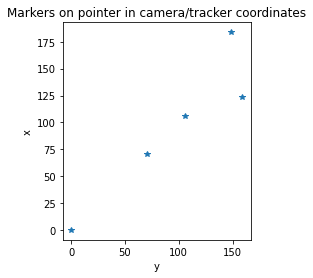

In [44]:
pnt_ref_in_camera_space =  np.zeros((4, 4))
pnt_ref_in_camera_space[0][3] = 1
pnt_ref_in_camera_space[1][0] = 50
pnt_ref_in_camera_space[1][3] = 1
pnt_ref_in_camera_space[2][0] = 100
pnt_ref_in_camera_space[2][1] = 25
pnt_ref_in_camera_space[2][3] = 1
pnt_ref_in_camera_space[3][0] = 135
pnt_ref_in_camera_space[3][1] = -25
pnt_ref_in_camera_space[3][3] = 1

offset_pointer_transform = create_transform([pointer_length, 0, 0, 0, 0, 0])
pnt_ref_in_camera_space_transformed = multiply_points_by_matrix(offset_pointer_transform, pnt_ref_in_camera_space, do_transpose=True)
pnt_ref_in_camera_space_with_tip = np.concatenate((pnt_ref_in_camera_space_transformed, [[0, 0, 0, 1]]), axis=0)

print("Pointer in camera/tracker space:\n" + str(pnt_ref_in_camera_space))
print("offset_pointer_transform=\n" + str(offset_pointer_transform))
print("pnt_ref_in_camera_space_transformed=\n" + str(pnt_ref_in_camera_space_transformed))
print("pnt_ref_in_camera_space_with_tip=\n" + str(pnt_ref_in_camera_space_with_tip))

# Now we want to rotate around z (according to diagram above), then translate to a distance from camera.
rotate_about_z = create_transform([0, 0, 0, 0, 0, pointer_angle]) 
translate_away_from_camera = create_transform([0, 0, distance_from_cam, 0, 0, 0])
pnt_ref_in_camera_space_at_patient = multiply_points_by_matrix(translate_away_from_camera @ rotate_about_z, pnt_ref_in_camera_space_with_tip, do_transpose=True)
print("pnt_ref_in_camera_space_at_patient=\n" + str(pnt_ref_in_camera_space_at_patient))

# Plotting result
plt.figure()
plt.plot(pnt_ref_in_camera_space_at_patient[:,1],pnt_ref_in_camera_space_at_patient[:,0], marker='*',linestyle = 'None',)
plt.title('Markers on pointer in camera/tracker coordinates')
plt.xlabel('y')
plt.ylabel('x')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

## Computing the Tracking transformation, Cam_T_PntRef.

For sanity checking, we should now be able to register the PntRef model (moving) to Cam (fixed) transform.

In [45]:
Cam_T_PntRef_r, Cam_T_PntRef_t, Cam_T_PntRef_FRE = pro.orthogonal_procrustes(pnt_ref_in_camera_space_at_patient[:,0:3], pnt_ref_with_tip[:,0:3])
print("Cam_T_PntRef_r=\n" + str(Cam_T_PntRef_r))
print("Cam_T_PntRef_t=\n" + str(Cam_T_PntRef_t))
print("Cam_T_PntRef_FRE=\n" + str(Cam_T_PntRef_FRE))

# Also, construct a 4x4 tracking transformation. It should look like a rotation and a translation.
Cam_T_PntRef = mu.construct_rigid_transformation(Cam_T_PntRef_r, Cam_T_PntRef_t)
print("Cam_T_PntRef=\n" + str(Cam_T_PntRef))


Cam_T_PntRef_r=
[[ 1.38483821e-15 -7.07106781e-01  7.07106781e-01]
 [-1.62248986e-15  7.07106781e-01  7.07106781e-01]
 [-1.00000000e+00 -2.11636264e-15  0.00000000e+00]]
Cam_T_PntRef_t=
[[5.68434189e-14]
 [2.84217094e-14]
 [1.00000000e+03]]
Cam_T_PntRef_FRE=
3.759838749409412e-14
Cam_T_PntRef=
[[ 1.38483821e-15 -7.07106781e-01  7.07106781e-01  5.68434189e-14]
 [-1.62248986e-15  7.07106781e-01  7.07106781e-01  2.84217094e-14]
 [-1.00000000e+00 -2.11636264e-15  0.00000000e+00  1.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


## Creating reference data for the the Patient Reference

![real patient reference](./images/real_pat_ref.png)


![patient reference coordinates](./images/pointer_patref_marker.png)

In [46]:
# Defining reference coordibates in ref coords (from datasheet)
#A: x=0.00, y= 0.00, z=0.00 
#B: x=0.00, y= 28.59, z=41.02 
#C: x=0.00, y= 00.00, z=88.00 
#D: x=0.00, y=-44.32, z=40.45
    
# Encoding the reference marker points into a numpy matrix
pat_ref = np.zeros((4, 4))
pat_ref[0][3] = 1.0
pat_ref[1][1] = 28.59 
pat_ref[1][2] = 41.02
pat_ref[1][3] = 1.0
pat_ref[2][2] = 88 
pat_ref[2][3] = 1.0
pat_ref[3][1] = -44.32 
pat_ref[3][2] = 40.45
pat_ref[3][3] = 1.0

## Creating the reference data for the patient reference in camera space.

- we assume the patient reference centre is at the same level as the cancer and so the x coordinates are the same
- the distance in y direction between cancer and reference is known


![reminder of patient reference assumptions](./images/pat_ref_assumptions.png)

The patient reference model coordinates are in the YZ plane. In camera space, the X direction is vertical, the Z direction goes from the camera to the patient. So, in camera space, lets place these points in the ZY plane. So, all we have to do is swap the Y, Z coordinates, then translate to the patient, then translate along the negative Y axis to match the picture above. 


In [47]:
# Encoding the reference marker points into a numpy matrix, in camera space.
pat_ref_in_camera_space = np.zeros((4, 4))
pat_ref_in_camera_space[0][3] = 1.0 
pat_ref_in_camera_space[1][1] = 41.02
pat_ref_in_camera_space[1][2] = 28.59
pat_ref_in_camera_space[1][3] = 1.0
pat_ref_in_camera_space[2][1] = 88 
pat_ref_in_camera_space[2][3] = 1.0
pat_ref_in_camera_space[3][1] = 40.45
pat_ref_in_camera_space[3][2] = -44.32 
pat_ref_in_camera_space[3][3] = 1.0

# Now put it in the right place.
translate_along_negative_y = create_transform([0, -cancer_patref_y, 0, 0, 0, 0])
pat_ref_in_camera_space_at_patient = multiply_points_by_matrix(translate_along_negative_y @ translate_away_from_camera, pat_ref_in_camera_space, do_transpose=True)

print("Patient ref, in model coordinates=\n" + str(pat_ref))
print("Patient ref, in camera coordinates=\n" + str(pat_ref_in_camera_space_at_patient))



Patient ref, in model coordinates=
[[  0.     0.     0.     1.  ]
 [  0.    28.59  41.02   1.  ]
 [  0.     0.    88.     1.  ]
 [  0.   -44.32  40.45   1.  ]]
Patient ref, in camera coordinates=
[[ 0.00000e+00 -5.00000e+01  1.00000e+03  1.00000e+00]
 [ 0.00000e+00 -8.98000e+00  1.02859e+03  1.00000e+00]
 [ 0.00000e+00  3.80000e+01  1.00000e+03  1.00000e+00]
 [ 0.00000e+00 -9.55000e+00  9.55680e+02  1.00000e+00]]


## Computing the Tracking transformation Cam_T_PntRef

In [48]:

# As above, compute the tracking transformation.
Cam_T_PatRef_r, Cam_T_PatRef_t, Cam_T_PatRef_FRE = pro.orthogonal_procrustes(pat_ref_in_camera_space_at_patient[:,0:3], pat_ref[:,0:3])
print("Cam_T_PatRef_r=\n" + str(Cam_T_PatRef_r))
print("Cam_T_PatRef_t=\n" + str(Cam_T_PatRef_t))
print("Cam_T_PatRef_FRE=\n" + str(Cam_T_PatRef_FRE))

# Also, construct a 4x4 tracking transformation. It should look like a translation, with no rotation.
Cam_T_PatRef = mu.construct_rigid_transformation(Cam_T_PatRef_r, Cam_T_PatRef_t)
print("Cam_T_PatRef=\n" + str(Cam_T_PatRef))


Cam_T_PatRef_r=
[[-1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.46944695e-17  1.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00 -9.02056208e-17]]
Cam_T_PatRef_t=
[[   0.]
 [ -50.]
 [1000.]]
Cam_T_PatRef_FRE=
7.105427357601002e-15
Cam_T_PatRef=
[[-1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.46944695e-17  1.00000000e+00 -5.00000000e+01]
 [ 0.00000000e+00  1.00000000e+00 -9.02056208e-17  1.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


## CT to PatRef coordinates

In order to convert CT coordinates to patient reference coordinates, we typically would take the pointer and move it over the surface of the patient's head. The software would collect coordinates of the tip of the pointer, and transform them to the patient reference coordinate system. We then use an ICP algorithm to match the two surfaces of the points on the face. This results in PatRef_T_MRI as shown above.

For the purpose of this simulation, we can just place them at an offset to the patient reference, which has already been placed, somewhere near the patients head.

![MRI to camera coordinates](./images/3D_to_cam.png)

In [49]:
# Average head dimensions from: https://en.wikipedia.org/wiki/Human_head

x_t = 100 # head length (about 20cm)
y_t = 130 # menton to top of head (about 25cm)
z_t = 80 # head breadth (about 15cm)

PatRef_T_MRI = create_transform([-x_t, -y_t, -z_t, 0, 0, 0])
print("Cam_T_PntRef=\n" + str(PatRef_T_MRI))

Cam_T_PntRef=
[[   1.    0.    0. -100.]
 [   0.    1.    0. -130.]
 [   0.    0.    1.  -80.]
 [   0.    0.    0.    1.]]


# Summary of Reference data.

Give this setup:

![pointer setup with transforms](./images/pointer_setup_transforms.png)

we have now computed

In [50]:
print("Summary: Cam_T_PntRef=\n" + str(Cam_T_PntRef))
print("Summary: Cam_T_PatRef=\n" + str(Cam_T_PatRef))
print("Summary: PatRef_T_MRI=\n" + str(PatRef_T_MRI))

Summary: Cam_T_PntRef=
[[ 1.38483821e-15 -7.07106781e-01  7.07106781e-01  5.68434189e-14]
 [-1.62248986e-15  7.07106781e-01  7.07106781e-01  2.84217094e-14]
 [-1.00000000e+00 -2.11636264e-15  0.00000000e+00  1.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Summary: Cam_T_PatRef=
[[-1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.46944695e-17  1.00000000e+00 -5.00000000e+01]
 [ 0.00000000e+00  1.00000000e+00 -9.02056208e-17  1.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Summary: PatRef_T_MRI=
[[   1.    0.    0. -100.]
 [   0.    1.    0. -130.]
 [   0.    0.    1.  -80.]
 [   0.    0.    0.    1.]]


and dont forget that we constructed the pointer, so that the origin is the tip, and we computed Cam_T_PntRef based on this. So, in the above diagram, PntRef_T_EndP is effectively the identity transformation.

In addition, we can just place the tumour at the location given by the pointer tip:


In [51]:
origin = [0, 0, 0]
tumour_in_camera_space = multiply_point_by_matrix(Cam_T_PntRef, origin)
tumour_in_mri_space = pointer_to_mri(Cam_T_PntRef, Cam_T_PatRef, PatRef_T_MRI, origin)
print("Tumour location in camera space=\n" + str(tumour_in_camera_space))
print("Tumour location in MRI space=\n" + str(tumour_in_mri_space))


Tumour location in camera space=
[[5.68434189e-14]
 [2.84217094e-14]
 [1.00000000e+03]
 [1.00000000e+00]]
Tumour location in MRI space=
[[100.]
 [130.]
 [130.]
 [  1.]]


And we have the following reference data from above:

In [52]:
print("Pointer model=\n" + str(pnt_ref_with_tip))
print("Pointer model in camera space=\n" + str(pnt_ref_in_camera_space_at_patient))
print("Patient ref model=\n" + str(pat_ref))
print("Patient ref model in camera space=\n" + str(pat_ref_in_camera_space_at_patient))


Pointer model=
[[  0.   0. 100.   1.]
 [  0.   0. 150.   1.]
 [  0.  25. 200.   1.]
 [  0. -25. 235.   1.]
 [  0.   0.   0.   1.]]
Pointer model in camera space=
[[  70.71067812   70.71067812 1000.            1.        ]
 [ 106.06601718  106.06601718 1000.            1.        ]
 [ 123.74368671  159.09902577 1000.            1.        ]
 [ 183.84776311  148.49242405 1000.            1.        ]
 [   0.            0.         1000.            1.        ]]
Patient ref model=
[[  0.     0.     0.     1.  ]
 [  0.    28.59  41.02   1.  ]
 [  0.     0.    88.     1.  ]
 [  0.   -44.32  40.45   1.  ]]
Patient ref model in camera space=
[[ 0.00000e+00 -5.00000e+01  1.00000e+03  1.00000e+00]
 [ 0.00000e+00 -8.98000e+00  1.02859e+03  1.00000e+00]
 [ 0.00000e+00  3.80000e+01  1.00000e+03  1.00000e+00]
 [ 0.00000e+00 -9.55000e+00  9.55680e+02  1.00000e+00]]


which are the 4 sets of points that we computed tracking transformations from, using orthogonal procrustes.

# Simulation 1: Effect of tracking noise on pointer tip accuracy.

Here we add random noise to the location of the tracking markers (pointer and patient ref) and see how far tip position moves relative to the tumour.

### Pseudo code

* initialise some arrays to store accuracy data, so we can then compute mean/stddev.
* for sigma in 0 to 0.5, in steps of 0.05
*   for iteration in 1 to 1000.
*     add zero mean Gaussian(sigma) noise to each tracking marker. 
*     recompute transforms.
*     recompute position of pointer tip
*     measure Euclidean distance in MRI space
*   compute RMS error over each iteration
* produce graph of RMS (TRE) for each value of sigma


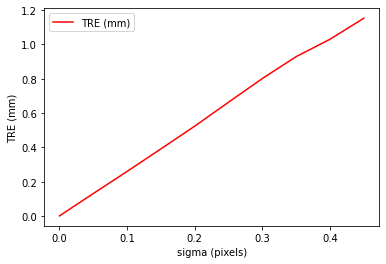

In [53]:
number_samples = 1000
x_values = []
y_values = []
for sigma_counter in range(0, 50, 5):
    sigma = float(sigma_counter) / float(100)
    rms = 0
    for i in range(number_samples):
        tmp_pointer = add_noise_to_points(pnt_ref_in_camera_space_at_patient[0:4,0:3], sigma) # Mustn't include pointer tip! 
        tmp_ref = add_noise_to_points(pat_ref_in_camera_space_at_patient[:,0:3], sigma)
        
        R, t, FRE = pro.orthogonal_procrustes(tmp_pointer, pnt_ref_with_tip[0:4, 0:3])
        tmp_pointer_to_cam = mu.construct_rigid_transformation(R, t)
        
        R, t, FRE = pro.orthogonal_procrustes(tmp_ref, pat_ref[0:4, 0:3])
        tmp_reference_to_cam = mu.construct_rigid_transformation(R, t)
        
        pointer_tip_in_mri_space = pointer_to_mri(tmp_pointer_to_cam, tmp_reference_to_cam, PatRef_T_MRI, origin)
        
        euclid_dist =  (pointer_tip_in_mri_space[0] - tumour_in_mri_space[0]) \
                     * (pointer_tip_in_mri_space[0] - tumour_in_mri_space[0]) \
                     + (pointer_tip_in_mri_space[1] - tumour_in_mri_space[1]) \
                     * (pointer_tip_in_mri_space[1] - tumour_in_mri_space[1]) \
                     + (pointer_tip_in_mri_space[2] - tumour_in_mri_space[2]) \
                     * (pointer_tip_in_mri_space[2] - tumour_in_mri_space[2])
        
        rms = rms + euclid_dist
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    x_values.append(sigma)
    y_values.append(rms)
    
plt.plot(x_values, y_values, 'r', label='TRE (mm)')
plt.legend(loc='upper left')
plt.xlabel('sigma (pixels)')
plt.ylabel('TRE (mm)')
plt.show()
        

        
        

# Variation of pointer length #

The way this code is written, the pointer length is used to generate the test data. Also vendors provide a specific pointer. So, in practice we wont be responsible for designing a new pointer. 

To study the effect of pointer length, just vary the parameter 'pointer_length' above, and re-run the simulation.


# Simulation 2: Effect of misregistration of pre-op data

The total system accuracy will be affected by the PatRef_T_MRI transformation. This is achieved using a point-based-registration (PBR), or an ICP surface-based-registration. However, ultimately, both produce a rigid matrix. If we decompose the PatRef_T_MRI matrix into individual rotations and translations, we can study the effect of registration error, as noise is added to these rotation and translation parameters.

In [54]:
# These are the baseline parameters for the MRI registration (whether thats PBR or SBR)
PatRef_T_MRI_parameters = extract_rigid_body_parameters(PatRef_T_MRI)
print("PatRef_T_MRI=\n" + str(PatRef_T_MRI))
print("PatRef_T_MRI_parameters=" + str(PatRef_T_MRI_parameters))

PatRef_T_MRI=
[[   1.    0.    0. -100.]
 [   0.    1.    0. -130.]
 [   0.    0.    1.  -80.]
 [   0.    0.    0.    1.]]
PatRef_T_MRI_parameters=[0.0, 0.0, 0.0, -100.0, -130.0, -80.0]


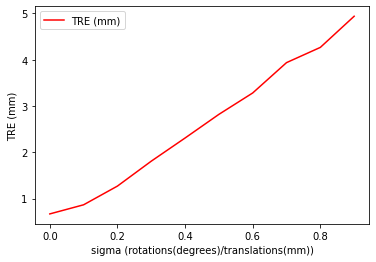

In [55]:
number_samples = 1000
x_values = []
y_values = []
for sigma_counter in range(0, 10, 1):
    sigma = float(sigma_counter) / float(10)
    rms = 0
    for i in range(number_samples):
        
        # Here we add tracking noise to the pointer and reference.
        tmp_pointer = add_noise_to_points(pnt_ref_in_camera_space_at_patient[0:4,0:3], typical_tracking_sigma) # Mustn't include pointer tip! 
        tmp_ref = add_noise_to_points(pat_ref_in_camera_space_at_patient[:,0:3], typical_tracking_sigma)
        
        # Here we add noise onto the PatRef_T_MRI_parameters, and reconstruct a new registration
        tmp_params = add_noise_to_params(PatRef_T_MRI_parameters, sigma)
        tmp_mri_to_patref = rigid_body_parameters_to_matrix(tmp_params)
        
        R, t, FRE = pro.orthogonal_procrustes(tmp_pointer, pnt_ref_with_tip[0:4, 0:3])
        tmp_pointer_to_cam = mu.construct_rigid_transformation(R, t)
        
        R, t, FRE = pro.orthogonal_procrustes(tmp_ref, pat_ref[0:4, 0:3])
        tmp_reference_to_cam = mu.construct_rigid_transformation(R, t)
        
        pointer_tip_in_mri_space = pointer_to_mri(tmp_pointer_to_cam, tmp_reference_to_cam, tmp_mri_to_patref, origin)
        
        euclid_dist =  (pointer_tip_in_mri_space[0] - tumour_in_mri_space[0]) \
                     * (pointer_tip_in_mri_space[0] - tumour_in_mri_space[0]) \
                     + (pointer_tip_in_mri_space[1] - tumour_in_mri_space[1]) \
                     * (pointer_tip_in_mri_space[1] - tumour_in_mri_space[1]) \
                     + (pointer_tip_in_mri_space[2] - tumour_in_mri_space[2]) \
                     * (pointer_tip_in_mri_space[2] - tumour_in_mri_space[2])
        
        rms = rms + euclid_dist
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    x_values.append(sigma)
    y_values.append(rms)
    
plt.plot(x_values, y_values, 'r', label='TRE (mm)')
plt.legend(loc='upper left')
plt.xlabel('sigma (rotations(degrees)/translations(mm))')
plt.ylabel('TRE (mm)')
plt.show()
        


# Summary of Model 1

Experiment 1 shows that for a pointer of length X, we would expect the tracking error, when transformed into MRI/CT space to be of the order of Y.

This paper here: http://dx.doi.org/10.1118/1.4898103 suggests to me that errors in translation and rotation for a surface based registration might be of the order of 0.5-1.0 mm or degrees. 

Combining the two, with a tracking sigma of 0.25mm, and expecting rotations and translation errors of between 0.5 and 1.0mm or degress, we would expect total system error to be between 2.5 and 5mm. 


# Model 2: Accuracy of AR using tracked endoscope

In Model 1, we studied the accuracy of measuring a point in 3D space, using a tracked pointer, and converting that to a point in the MR/CT scan, via registration.

In Model 2, we want to study the accuracy of a tracked endoscope, and what the expected accuracy of an overlay will be. The overlay accuracy, could be measured in terms of accuracy in 3D in the endoscope camera frame, or in terms of 2D pixel accuracy.

In order to make this a like-for-like comparison, we should keep most of the reference data identical. The difference now, is we swap a pointer for a laparoscope. We will need an additional hand-eye calibration, and reference data to project from camera space onto image space, but we leave all other data the same. 

## Recap of Reference Data so far

In [56]:
# Endoscope tracking
endoscope_markers_in_camera_space = pnt_ref_in_camera_space_at_patient[0:4,0:3]
endoscope_markers_in_marker_space = pnt_ref_with_tip[0:4,0:3]

print("endoscope_markers_in_camera_space=\n" + str(endoscope_markers_in_camera_space))
print("endoscope_markers_in_marker_space=\n" + str(endoscope_markers_in_marker_space))

Cam_T_Endo_r, Cam_T_Endo_t, Cam_T_Endo_FRE = pro.orthogonal_procrustes(endoscope_markers_in_camera_space, endoscope_markers_in_marker_space)
print('\n')
print("Cam_T_Endo_r=\n" + str(Cam_T_Endo_r))
print("Cam_T_Endo_t=\n" + str(Cam_T_Endo_t))
print("Cam_T_Endo_FRE=\n" + str(Cam_T_Endo_FRE))

Cam_T_Endo = mu.construct_rigid_transformation(Cam_T_Endo_r, Cam_T_Endo_t)
print('\n')
print("Cam_T_Endo=\n" + str(Cam_T_Endo))

# Patient ref tracking
print('\n')
print("Patient ref model=\n" + str(pat_ref))
print("Patient ref model in camera space=\n" + str(pat_ref_in_camera_space_at_patient))
print("Cam_T_PatRef_r=\n" + str(Cam_T_PatRef_r))
print("Cam_T_PatRef_t=\n" + str(Cam_T_PatRef_t))
print("Cam_T_PatRef_FRE=\n" + str(Cam_T_PatRef_FRE))
print("Cam_T_PatRef=\n" + str(Cam_T_PatRef))

# MRI to PatRef transform and parameters
print('\n')
print("PatRef_T_MRI=\n" + str(PatRef_T_MRI))
print("PatRef_T_MRI_parameters=" + str(PatRef_T_MRI_parameters))


endoscope_markers_in_camera_space=
[[  70.71067812   70.71067812 1000.        ]
 [ 106.06601718  106.06601718 1000.        ]
 [ 123.74368671  159.09902577 1000.        ]
 [ 183.84776311  148.49242405 1000.        ]]
endoscope_markers_in_marker_space=
[[  0.   0. 100.]
 [  0.   0. 150.]
 [  0.  25. 200.]
 [  0. -25. 235.]]


Cam_T_Endo_r=
[[ 1.59218830e-16 -7.07106781e-01  7.07106781e-01]
 [-1.92482452e-16  7.07106781e-01  7.07106781e-01]
 [-1.00000000e+00 -2.77555756e-16  0.00000000e+00]]
Cam_T_Endo_t=
[[2.84217094e-14]
 [0.00000000e+00]
 [1.00000000e+03]]
Cam_T_Endo_FRE=
1.2306961192854808e-14


Cam_T_Endo=
[[ 1.59218830e-16 -7.07106781e-01  7.07106781e-01  2.84217094e-14]
 [-1.92482452e-16  7.07106781e-01  7.07106781e-01  0.00000000e+00]
 [-1.00000000e+00 -2.77555756e-16  0.00000000e+00  1.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Patient ref model=
[[  0.     0.     0.     1.  ]
 [  0.    28.59  41.02   1.  ]
 [  0.     0.    88.     1.  ]
 

## Laparoscope specific parameters

Previously the length of the pointer was specified in the variable: pointer_length, typically about 100mm.

(To Do, actually measure the medtronic one).

We need a function to create a hand-eye transformation, between the tracking marker on the laparoscope, and the camera coordinate system.


In [57]:
def create_hand_eye(length_of_endoscope):
    transform = np.eye(4)
    transform[2][3] = -(pointer_length - length_of_endoscope)
    return transform

### Check hand-eye is working

If you look at the above coordinates in the variable endoscope_markers_in_marker_space, then the tracking ball nearest the tip has a +ve z coordinate of 100. If we move towards the pointer/laparoscope tip, you'd expect the z-coordinate to decrease. Furthermore, if we imagine that the laparoscope is 30cm/300mm long, then a point that is 300mm from the tracking ball would have z-coordinate -200. So, if we multiple [0, 0, -200] by hand-eye (i.e. the marker-to-camera transformation, we would expect the [0, 0, -200] to be mapped to [0, 0, 0], i.e the centre of projection of the laparoscope. 

In [58]:
cop_in_laparascope_marker_space=np.zeros((4,1))
cop_in_laparascope_marker_space[2][0] = -200
cop_in_laparascope_marker_space[3][0] = 1
hand_eye = create_hand_eye(length_of_endoscope)
cop_in_camera_space = multiply_point_by_matrix(hand_eye, cop_in_laparascope_marker_space)
print("Input=" + str(cop_in_laparascope_marker_space))
print("Transform=" + str(hand_eye))
print("Output=" + str(cop_in_camera_space))

Input=[[   0.]
 [   0.]
 [-200.]
 [   1.]]
Transform=[[  1.   0.   0.   0.]
 [  0.   1.   0.   0.]
 [  0.   0.   1. 200.]
 [  0.   0.   0.   1.]]
Output=[[0.]
 [0.]
 [0.]
 [1.]]


## Target Point in Camera and MRI space

Imagine that the working distance of the endoscope is about 5cm? (ToDo, check this for something realistic). Then we need to know the location of the target point in camera, and world space.

In [59]:


target_location_in_camera_space = np.zeros((4,1))
target_location_in_camera_space[2][0] = working_distance
target_location_in_camera_space[3][0] = 1

target_location_in_mri_space = camera_to_mri(Cam_T_Endo, Cam_T_PatRef, PatRef_T_MRI, hand_eye, target_location_in_camera_space)

print("Target in camera space=" + str(target_location_in_camera_space))
print("Target in MRI space=" + str(target_location_in_mri_space))


Target in camera space=[[ 0.]
 [ 0.]
 [50.]
 [ 1.]]
Target in MRI space=[[206.06601718]
 [130.        ]
 [ 23.93398282]
 [  1.        ]]


We now have a laparoscope system set up. Let's simulate what the effect of tracker noise is on 3D and 2D overlay accuracy, and also registration errors (mm/degrees), on both 3D and 2D overlay accuracy. 

# Simulation 3: Effect of Tracker Noise on Endoscope System

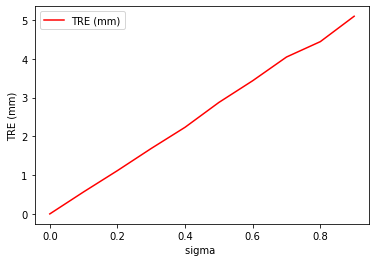

In [69]:
number_samples = 1000
x_values = []
y_values = []
for sigma_counter in range(0, 10, 1):
    sigma = float(sigma_counter) / float(10)
    rms = 0
    for i in range(number_samples):
        
        # Here we add tracking noise to the endoscope and reference.
        tmp_endoscope = add_noise_to_points(endoscope_markers_in_camera_space, sigma) # Mustn't include pointer tip! 
        tmp_ref = add_noise_to_points(pat_ref_in_camera_space_at_patient[:,0:3], sigma)

        R, t, FRE = pro.orthogonal_procrustes(tmp_endoscope, endoscope_markers_in_marker_space)
        tmp_endoscope_to_cam = mu.construct_rigid_transformation(R, t)
        
        
        R, t, FRE = pro.orthogonal_procrustes(tmp_ref, pat_ref[0:4, 0:3])
        tmp_reference_to_cam = mu.construct_rigid_transformation(R, t)
        
        transformed_point = camera_to_mri(tmp_endoscope_to_cam, tmp_reference_to_cam, PatRef_T_MRI, hand_eye, target_location_in_camera_space)

        
        euclid_dist =  (transformed_point[0] - target_location_in_mri_space[0]) \
                     * (transformed_point[0] - target_location_in_mri_space[0]) \
                     + (transformed_point[1] - target_location_in_mri_space[1]) \
                     * (transformed_point[1] - target_location_in_mri_space[1]) \
                     + (transformed_point[2] - target_location_in_mri_space[2]) \
                     * (transformed_point[2] - target_location_in_mri_space[2])
        
        #print(euclid_dist)

        rms = rms + euclid_dist
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    x_values.append(sigma)
    y_values.append(rms)
    
plt.plot(x_values, y_values, 'r', label='TRE (mm)')
plt.legend(loc='upper left')
plt.xlabel('sigma ')
plt.ylabel('TRE (mm)')
plt.show()
        


# Simulation 4: Tracking error + Registration error for Endoscope System

As above, we'd like to simulate the effects of registration error, as well as tracking error.


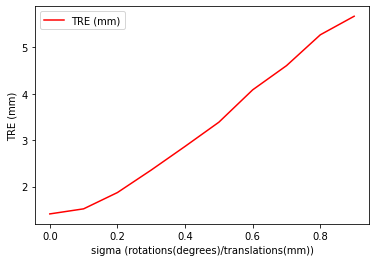

In [70]:
number_samples = 1000
x_values = []
y_values = []
for sigma_counter in range(0, 10, 1):
    sigma = float(sigma_counter) / float(10)
    rms = 0
    for i in range(number_samples):
        
        # Here we add tracking noise to the pointer and reference.
        tmp_endoscope = add_noise_to_points(endoscope_markers_in_camera_space, typical_tracking_sigma) # Mustn't include pointer tip! 
        tmp_ref = add_noise_to_points(pat_ref_in_camera_space_at_patient[:,0:3], typical_tracking_sigma)
        
        # Here we add noise onto the PatRef_T_MRI_parameters, and reconstruct a new registration
        tmp_params = add_noise_to_params(PatRef_T_MRI_parameters, sigma)
        tmp_mri_to_patref = rigid_body_parameters_to_matrix(tmp_params)
        
        R, t, FRE = pro.orthogonal_procrustes(tmp_endoscope, endoscope_markers_in_marker_space)
        tmp_endoscope_to_cam = mu.construct_rigid_transformation(R, t)
        
        R, t, FRE = pro.orthogonal_procrustes(tmp_ref, pat_ref[0:4, 0:3])
        tmp_reference_to_cam = mu.construct_rigid_transformation(R, t)
        
        transformed_point = camera_to_mri(tmp_endoscope_to_cam, tmp_reference_to_cam, tmp_mri_to_patref, hand_eye, target_location_in_camera_space)
        
        euclid_dist =  (transformed_point[0] - target_location_in_mri_space[0]) \
                     * (transformed_point[0] - target_location_in_mri_space[0]) \
                     + (transformed_point[1] - target_location_in_mri_space[1]) \
                     * (transformed_point[1] - target_location_in_mri_space[1]) \
                     + (transformed_point[2] - target_location_in_mri_space[2]) \
                     * (transformed_point[2] - target_location_in_mri_space[2])
        
        rms = rms + euclid_dist
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    x_values.append(sigma)
    y_values.append(rms)
    
plt.plot(x_values, y_values, 'r', label='TRE (mm)')
plt.legend(loc='upper left')
plt.xlabel('sigma (rotations(degrees)/translations(mm))')
plt.ylabel('TRE (mm)')
plt.show()
     

# Simulation 5: Effect of Hand-Eye and Tracking Error in Endoscope System

In addition to above, what if we vary hand-eye, is this better/worse, meaning less/more important to get right than the registration?

Matt: The problem with this experiment, is we don't yet know how variable a typical hand-eye calibration is. Imagine the scenario where 10 different members of staff, did 10 different calibrations, and we looked at the standard-deviation (sigma) of the rotation parameters, and translation parameters. Would they be within the range of sigma of 0-1? If they are much worse, then the numbers below will need adjusting.

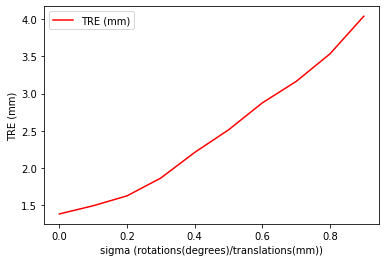

In [71]:
Hand_T_Eye_parameters = extract_rigid_body_parameters(hand_eye)

number_samples = 1000
x_values = []
y_values = []
for sigma_counter in range(0, 10, 1):
    sigma = float(sigma_counter) / float(10)
    rms = 0
    for i in range(number_samples):
        
        # Here we add tracking noise to the pointer and reference.
        tmp_endoscope = add_noise_to_points(endoscope_markers_in_camera_space, typical_tracking_sigma) # Mustn't include pointer tip! 
        tmp_ref = add_noise_to_points(pat_ref_in_camera_space_at_patient[:,0:3], typical_tracking_sigma)
        
        # Here we add noise onto the PatRef_T_MRI_parameters, and reconstruct a new registration
        tmp_hand_eye_params = add_noise_to_params(Hand_T_Eye_parameters, sigma)
        tmp_hand_eye = rigid_body_parameters_to_matrix(tmp_hand_eye_params)
        
        R, t, FRE = pro.orthogonal_procrustes(tmp_endoscope, endoscope_markers_in_marker_space)
        tmp_endoscope_to_cam = mu.construct_rigid_transformation(R, t)
        
        R, t, FRE = pro.orthogonal_procrustes(tmp_ref, pat_ref[0:4, 0:3])
        tmp_reference_to_cam = mu.construct_rigid_transformation(R, t)
        
        transformed_point = camera_to_mri(tmp_endoscope_to_cam, tmp_reference_to_cam, PatRef_T_MRI, tmp_hand_eye, target_location_in_camera_space)
        
        euclid_dist =  (transformed_point[0] - target_location_in_mri_space[0]) \
                     * (transformed_point[0] - target_location_in_mri_space[0]) \
                     + (transformed_point[1] - target_location_in_mri_space[1]) \
                     * (transformed_point[1] - target_location_in_mri_space[1]) \
                     + (transformed_point[2] - target_location_in_mri_space[2]) \
                     * (transformed_point[2] - target_location_in_mri_space[2])
        
        rms = rms + euclid_dist
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    x_values.append(sigma)
    y_values.append(rms)
    
plt.plot(x_values, y_values, 'r', label='TRE (mm)')
plt.legend(loc='upper left')
plt.xlabel('sigma (rotations(degrees)/translations(mm))')
plt.ylabel('TRE (mm)')
plt.show()
     

# Simulation 6: In AR How Many Pixels Off?

The above simulations simply measure the true 3D distance in MRI space. So, given tracking errors, and either hand-eye or registration errors, how far off would we be if we mapped back to MRI space. (Similarly we could run the application the other way round, and express this in camera space, but the error would be the same).

But, given that the field of view is so, small, how many pixels would this amount to? Most endoscopes run on 1920x1080p Full HD, on a reasonable monitor. So, how many pixels off are we?

In the simulation below, we will assume we are dealing with a perfect hand-eye calibration, and repeat the experiment that investigated errors in registration, but this time, projecting to the image coordinates, and measuring the distance in pixels. If subsequent lab experiments show that hand-eye is more critical, then the experiment below can be repeated, but varying the hand-eye instead of the registration.

In [26]:
# Camera calibration
intrinsics = np.loadtxt('calibration/intrinsics.txt')
distortion = np.loadtxt('calibration/distortion.txt')

print("Intrinsics are:" + str(intrinsics))
print("Distortion coefficients are:" + str(distortion))

# Need to project target point to image plane. Incidentally, the target point 
# was straight along the optical axis, so should project to the middle of the image.
target_location_in_image_coordinates = project_camera_point_to_image(target_location_in_camera_space, intrinsics, distortion)
print("target_location_in_image_coordinates=" + str(target_location_in_image_coordinates))

Intrinsics are:[[1.62188148e+03 0.00000000e+00 7.97383573e+02]
 [0.00000000e+00 1.62275557e+03 5.76112074e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion coefficients are:[-0.430378  0.242636 -0.003683  0.001973 -0.082406]
target_location_in_image_coordinates=[797.383573 576.112074]


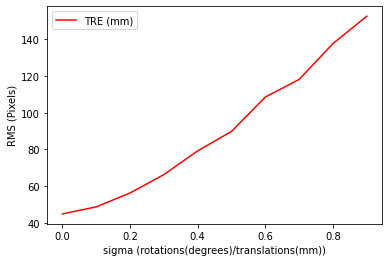

In [27]:
number_samples = 1000
x_values = []
y_values = []
for sigma_counter in range(0, 10, 1):
    sigma = float(sigma_counter) / float(10)
    rms = 0
    for i in range(number_samples):
        
        # Here we add tracking noise to the pointer and reference.
        tmp_endoscope = add_noise_to_points(endoscope_markers_in_camera_space, typical_tracking_sigma) # Mustn't include pointer tip! 
        tmp_ref = add_noise_to_points(pat_ref_in_camera_space_at_patient[:,0:3], typical_tracking_sigma)
        
        # Here we add noise onto the PatRef_T_MRI_parameters, and reconstruct a new registration
        tmp_params = add_noise_to_params(PatRef_T_MRI_parameters, sigma)
        tmp_mri_to_patref = rigid_body_parameters_to_matrix(tmp_params)
        
        R, t, FRE = pro.orthogonal_procrustes(tmp_endoscope, endoscope_markers_in_marker_space)
        tmp_endoscope_to_cam = mu.construct_rigid_transformation(R, t)
        
        R, t, FRE = pro.orthogonal_procrustes(tmp_ref, pat_ref[0:4, 0:3])
        tmp_reference_to_cam = mu.construct_rigid_transformation(R, t)
        
        transformed_point_in_camera_space = mri_to_camera(tmp_endoscope_to_cam, tmp_reference_to_cam, tmp_mri_to_patref, hand_eye, target_location_in_mri_space)
        transformed_point_in_image_space = project_camera_point_to_image(transformed_point_in_camera_space, intrinsics, distortion)

        euclid_dist =  (transformed_point_in_image_space[0] - target_location_in_image_coordinates[0]) \
                     * (transformed_point_in_image_space[0] - target_location_in_image_coordinates[0]) \
                     + (transformed_point_in_image_space[1] - target_location_in_image_coordinates[1]) \
                     * (transformed_point_in_image_space[1] - target_location_in_image_coordinates[1]) 
        
        rms = rms + euclid_dist
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    x_values.append(sigma)
    y_values.append(rms)
    
plt.plot(x_values, y_values, 'r', label='TRE (mm)')
plt.legend(loc='upper left')
plt.xlabel('sigma (rotations(degrees)/translations(mm))')
plt.ylabel('RMS (Pixels)')
plt.show()


# Summary of Model 2

It's interesting to compare 3D errors, and the subsequent effect in pixels in 2D. 

From Simulation 3, we can see that with an NDI Polaris Spectra that has a sigma of 0.25, we would expect to get TREs of about 1.5mm. Furthermore, if we upgraded to the latest Veiga, which has a sigma of about 0.12, we might achieve TREs around 0.5mm. 

In Simulation 4, and assuming from the literature that rotational errors and translational errors of surface based registration are 0.5-1.0 mm/degrees, then we might expect TRE errors of about 3-6mm. (TODO: Can we do a surface based registration experiment ourselves?)

In simulation 5, we can see that with an NDI Polaris Spectra that has a sigma of 0.25, and simulating Hand-Eye calibration errors with sigma 0-1 for rotational and translational parameters, we see that if errors are in the 0.5-1.0mm/degrees level, then we might expect TRE errors of about 2.75-4.0mm. (TODO: We need to do some calibrations and get realistic values for intrinsic, distortion, and distance from camera.)

Simulation 6 shows us that given a perfect hand-eye, and if we again use a sigma of 0.5-1.0 mm/degrees for the registration performance, and a 'typical' level of noise on tracking markers (e.g. like Simulation 4), that TRE of around 3-6mm would map to 80 - 140 pixels. Given that a modern endoscope is 1920x1080, (full HD), then we would expect errors between 4-7% of the screen width and 7-13%& in height, which will look pretty terrible.
